# Import Packages

In [1]:
# Default packages
import os
from os.path import join
from datetime import date, datetime, timedelta
from joblib import load, dump

# Set current directory to "src"
os.chdir(join(os.getcwd(), os.pardir, "src"))
print(f"Current working directory: {os.getcwd()}")

# Installed packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Defined modules
from util.util import *
# from config.config import *
from process.dataloader import Data
from process.embed_gen import EmbedGen
from process.evaluate import *
from models import lstm_vae, cnn_vae
from models.lstm_ae import lstm_autoencoder
from models.lstm import basic_lstm
from visualize import plot

# Set TF log level to minimum
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Check GPU availability
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Current working directory: e:\Repositories\PCovNet\src
Found GPU at: /device:GPU:0


# Process Config

In [2]:
config = {
    'EXP_NAME': "trial",
    'EXP_PHASE': "phase1",
    'EXP_GROUP': "covid",
    'AUGMENT_DATA': True,
    'ONLY_NIGHT_DATA': False,
    'MODEL_DIR': None,
    'TRAIN_VAE': True,
    'TRAIN_LSTM': True,
    'LEN_WIN': 24,
    'N_WIN': 7,
    'LATENT_DIM': 6,
    'BATCH_SIZE': 64,
    'VAL_SPLIT': 0.05,
    'LEARNING_RATE': 0.0002,
    'EPOCH': 1000,
    'PATIENCE': 10,
}


In [3]:
# Dictionaries of dataset paths
DATA_DIR_DICT = {
    'phase1': join(os.getcwd(), os.pardir, "data", "raw", "phase1"),
    'phase2': join(os.getcwd(), os.pardir, "data", "raw", "phase2")
}
INFO_DIR_DICT = {
    'covid_phase1': join(os.getcwd(), os.pardir, "data", "external", "covid_phase1_info.csv"),
    'covid_phase2': join(os.getcwd(), os.pardir, "data", "external", "covid_phase2_info.csv"),
    'healthy_phase1': join(os.getcwd(), os.pardir, "data", "external", "healthy_phase1_info.csv"),
    'non-covid_phase1': join(os.getcwd(), os.pardir, "data", "external", "non-covid_phase1_info.csv"),
}

# Import subject info
subject_info = pd.read_csv(
    INFO_DIR_DICT[f"{config['EXP_GROUP']}_{config['EXP_PHASE']}"])


# Assign experiment directory
config['EXP_DIR'] = join(os.getcwd(), os.pardir, "experiment",
                         config['EXP_NAME'])
# timestamp = datetime.now().strftime(f"%Y-%m-%d %H-%M__")
# config['EXP_DIR'] = join(os.getcwd(), os.pardir, "experiment",
#                          timestamp + config['EXP_NAME'])
handle_dir(config['EXP_DIR'])


# Add DATA_DIR
config['DATA_DIR'] = DATA_DIR_DICT[config['EXP_PHASE']]


# Export config
export_json(config, join(config['EXP_DIR'], "config.json"),
            print_json=True)

# Start logging
with open(join(config['EXP_DIR'], "log.txt"), 'w', encoding='utf-8') as f:
    for key, value in config.items():
        f.write(f"{key}: {value}\n")
    f.write("\n\n")


config
{
    "EXP_NAME": "trial",
    "EXP_PHASE": "phase1",
    "EXP_GROUP": "covid",
    "AUGMENT_DATA": true,
    "ONLY_NIGHT_DATA": false,
    "MODEL_DIR": null,
    "TRAIN_VAE": true,
    "TRAIN_LSTM": true,
    "LEN_WIN": 24,
    "N_WIN": 7,
    "LATENT_DIM": 6,
    "BATCH_SIZE": 64,
    "VAL_SPLIT": 0.05,
    "LEARNING_RATE": 0.0002,
    "EPOCH": 1000,
    "PATIENCE": 10,
    "EXP_DIR": "e:\\Repositories\\PCovNet\\src\\..\\experiment\\trial",
    "DATA_DIR": "e:\\Repositories\\PCovNet\\src\\..\\data\\raw\\phase1"
}


# Import & Process Data

In [5]:
# Choose which data index from subject_info to run the experiment on
idx = 0
# for idx in range(len(subject_info)):
# Prepare data
data = Data(config=config, data_info=subject_info, index=idx)

# Log data properties
if data.error == True:
    print(data.error_message)
    with open(join(config['EXP_DIR'], "log.txt"), 'a', encoding='utf-8') as f:
        f.write(
            f"Index {idx}\t {data.id} {'-'*4} Data properties... ✘ ... {data.error_message}\n")
    # Use continue if run in a loop; otherwise raise error
    # continue
    print(data.error_message)
    # raise ValueError("Data does not meet experiment criteria!")
else:
    print("Data properties... ✔\n")
    with open(join(config['EXP_DIR'], "log.txt"), 'a', encoding='utf-8') as f:
        f.write(f"Index {idx}\t {data.id} {'-'*4} Data properties... ✔\n")

# Print data info
# data.print_info()

# Export dates
# pd.DataFrame(data.date_dict, index=[0]).to_csv(
#     join(config['EXP_DIR'], data.id + "_dates.csv"), index=False)


No samples in LSTM train dataset!
No samples in LSTM train dataset!


In [11]:
print(data.train_dataset_vae.shape, data.train_dataset_lstm.shape)

(117, 24, 1) (0, 7, 24, 1)


# VAE Model

#### Assign and Compile VAE Model

In [5]:
# Get VAE model
vae_model = cnn_vae.VAE(n_timesteps=config['LEN_WIN'],
                        n_channels=data.train_dataset_vae.shape[-1],
                        latent_dim=config['LATENT_DIM'])
vae_model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(
                      learning_rate=config['LEARNING_RATE']),
                  metrics=[tf.metrics.MeanSquaredError()])

# Show VAE model summary
print("\nVAE Model Summary")
print("=================", end="\n\n")
vae_model.print_summary()



VAE Model Summary

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 48, 1)]      0           []                               
                                                                                                  
 encoder1 (Conv1D)              (None, 24, 128)      512         ['encoder_input[0][0]']          
                                                                                                  
 encoder2 (Conv1D)              (None, 12, 64)       24640       ['encoder1[0][0]']               
                                                                                                  
 encoder3 (Conv1D)              (None, 6, 32)        6176        ['encoder2[0][0]']               
                                                                        

#### Train VAE Model

In [6]:
# Assign checkpoint paths
tl_vae_ckpt_path = join(os.pardir, "experiment", "transfer_learning_48_8",
                        "vae_checkpoint", "ckpt")
vae_ckpt_path = join(
    config['EXP_DIR'], data.id + "_vae_checkpoint", "ckpt")

# Callbacks for VAE
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=config['PATIENCE'],
                                        mode='min',
                                        restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(vae_ckpt_path,
                                      monitor='val_loss',
                                      verbose=0,
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)

# Load learned weights for VAE
vae_model.load_weights(tl_vae_ckpt_path)

if config['TRAIN_VAE']:
    # Train VAE
    vae_history = vae_model.fit(data.train_aug_dataset_vae,
                                validation_split=config['VAL_SPLIT'],
                                batch_size=config['BATCH_SIZE'],
                                epochs=config['EPOCH'],
                                shuffle=False,
                                verbose=1,
                                callbacks=[early_stopping_callback, checkpoint_callback])

    # Export model history
    export_history(vae_history, join(
        config['EXP_DIR'], data.id + "_vae_history.csv"))

    # Plot loss curve
    # print("\nVAE Loss Curve")
    # print("==============", end="\n")
    plot.loss_curve(config, vae_history, ref=data.id + "_VAE", save_plot=True,
                    close_plot=True)


# Generate Embeddings

In [7]:
if config['TRAIN_LSTM']:
    if not os.path.isfile(join(config['EXP_DIR'], f"{data.id}_embeddings.joblib")):
        # Get embedding dataset
        embed_gen = EmbedGen(config, vae_model,
                            data, verbose=True)

        # Save embed_gen object
        dump(embed_gen, join(config['EXP_DIR'],
                            f"{data.id}_embeddings.joblib"))
    else:
        # Load embed_gen object
        embed_gen = load(join(config['EXP_DIR'], f"{data.id}_embeddings.joblib"))
        print("Embeddings loaded from:")
        print(join(config['EXP_DIR'], f"{data.id}_embeddings.joblib"))


# LSTM Model for Embeddings

#### Assign and Compile LSTM Model

In [8]:
# Get LSTM MODEL
lstm_model = lstm_autoencoder(n_timesteps=config['N_WIN'] - 1,
                              n_features=config['LATENT_DIM'])
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                   optimizer=tf.optimizers.Adam(
                       learning_rate=config['LEARNING_RATE']),
                   metrics=['mse'])

# Show LSTM model summary
print("\nLSTM Model Summary")
print("==================", end="\n\n")
lstm_model.summary()



LSTM Model Summary

Model: "LSTM_Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 6)]            0         
                                                                 
 encoder1 (LSTM)             (None, 7, 128)            69120     
                                                                 
 encoder2 (LSTM)             (None, 64)                49408     
                                                                 
 repeat_vec (RepeatVector)   (None, 7, 64)             0         
                                                                 
 decoder1 (LSTM)             (None, 7, 64)             33024     
                                                                 
 decoder2 (LSTM)             (None, 7, 128)            98816     
                                                                 
 reconst (TimeDistributed)   

#### Train LSTM Model

In [9]:
# Assign checkpoint paths
tl_lstm_ckpt_path = join(os.pardir, "experiment", "transfer_learning_48_8",
                         "lstm_checkpoint", "ckpt")
lstm_ckpt_path = join(
    config['EXP_DIR'], data.id + "_lstm_checkpoint", "ckpt")
    
# Callbacks for LSTM
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=config['PATIENCE'],
                                        mode='min',
                                        restore_best_weights=True)
checkpoint_callback = ModelCheckpoint(lstm_ckpt_path,
                                      monitor='val_loss',
                                      verbose=0,
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)

# Load learned weights for VAE
lstm_model.load_weights(tl_lstm_ckpt_path)

if config['TRAIN_LSTM']:
    # Train LSTM
    lstm_history = lstm_model.fit(embed_gen.x_train, embed_gen.y_train,
                                  validation_data=(
                                      embed_gen.x_test, embed_gen.y_test),
                                  batch_size=config['BATCH_SIZE'],
                                  epochs=config['EPOCH'],
                                  callbacks=[
                                      early_stopping_callback, checkpoint_callback],
                                  verbose=1)

    # Export model history
    export_history(lstm_history, join(
        config['EXP_DIR'], data.id + "_lstm_history.csv"))

    # Plot loss curve
    # print("\nLSTM Loss Curve")
    # print("===============", end="\n")
    plot.loss_curve(config, lstm_history, ref=data.id + "_LSTM", save_plot=True,
                    close_plot=True)


# Evaluate VAE Model

#### Calculate Loss for VAE Model

In [10]:
# Calculate vae losses
print("\n")
print("Calculate vae train loss... ", end="")
train_loss = vae_model.get_loss_array(data.train_dataset_vae)
print("✓")
print("Calculate vae test loss... ", end="")
test_loss = vae_model.get_loss_array(data.test_dataset_vae)
print("✓")
print("Calculate vae all loss... ", end="")
seq_loss = vae_model.get_loss_array(data.merged_dataset_vae)
print("✓")
print("\n")




Calculate vae train loss... ✓
Calculate vae test loss... ✓
Calculate vae all loss... ✓




#### Evaluate Results for VAE Model


Loss Distribution Plot


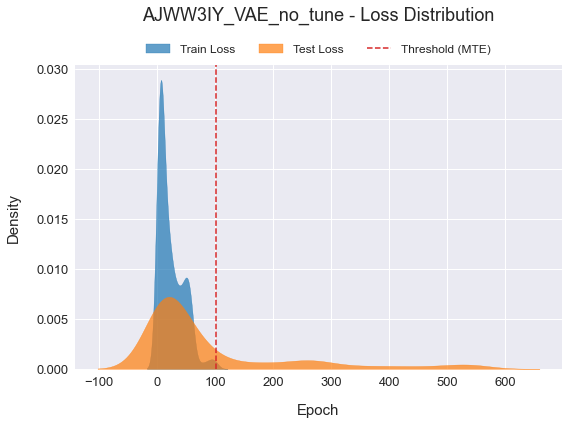


Metrics
{'Threshold': 'MTE', 'Detection': 'Early', 'Total': 315, 'TP': 27, 'FP': 1, 'FN': 85, 'TN': 202, 'Sensitivity': 0.24107142857142858, 'Specificity': 0.9950738916256158, 'PPV': 0.9642857142857143, 'NPV': 0.7038327526132404, 'Precision': 0.9642857142857143, 'Recall': 0.24107142857142858, 'Fbeta': 0.9364697802197803, 'F1': 0.3857142857142858}

RHR Plot


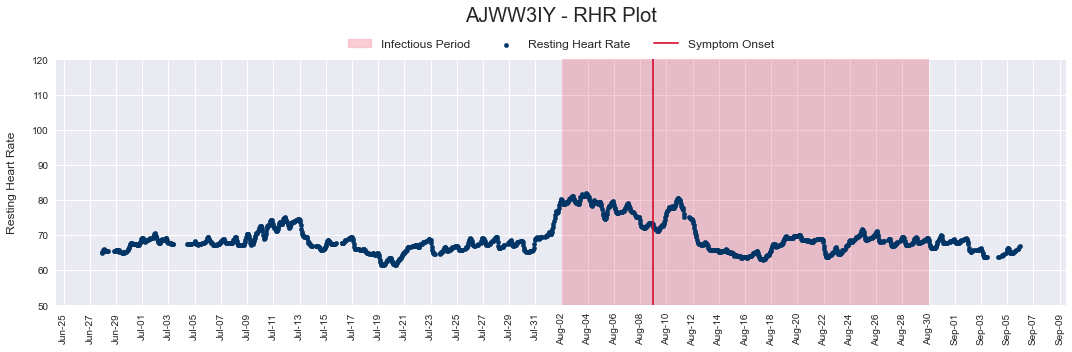


Anomaly Plot


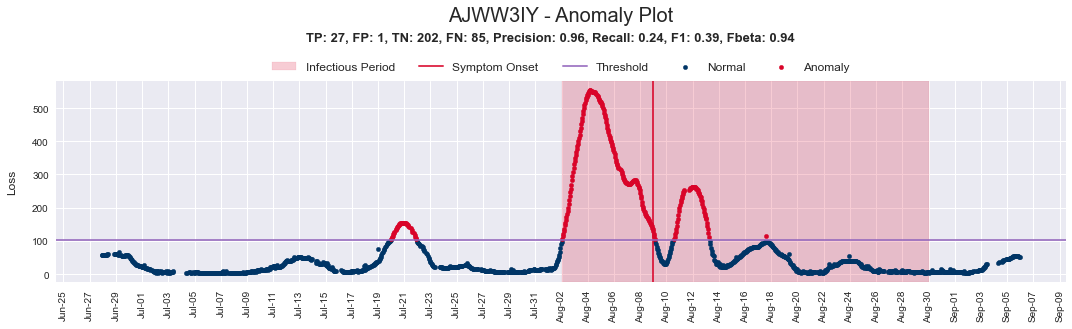

In [12]:
threshold_dict = {
    'MTE': train_loss.max(),
    # 'STE': train_loss.mean() + (3 * train_loss.std())
}

print("\nLoss Distribution Plot")
print("======================", end="\n")
plot.loss_dist(config, train_loss, test_loss, threshold_dict, ref=f"{data.id}_VAE_no_tune",
               save_plot=True, close_plot=False)

metrics, loss_df_dict = evaluate_model(config, data, train_loss, test_loss,
                                       seq_loss, threshold_dict, ref=f"{data.id}_VAE_no_tune")
print("\nMetrics")
print("=======", end="\n")
print(metrics)

print("\nRHR Plot")
print("========", end="\n")
# Plot RHR wrt infectious period
plot.rhr_plot(config, loss_df_dict['all'], data.date_dict, title=f"{data.id} - RHR Plot",
              ref=f"{data.id}_VAE_no_tune", save_plot=True, close_plot=False)

print("\nAnomaly Plot")
print("=============", end="\n")
# Plot anomalies
plot.anomaly_plot(config, loss_df_dict['all'], data.date_dict, threshold_dict['MTE'],
                  metrics, title=f"{data.id} - Anomaly Plot", ref=f"{data.id}_VAE_no_tune",
                  save_plot=True, close_plot=False)


# Evaluate LSTM Model

#### Calculate Loss for LSTM Model

In [13]:
# Calculate vae-lstm losses
print("\n")
print("Calculate lstm train loss... ", end="")
train_loss = get_vae_lstm_loss(data.train_dataset_lstm,
                               vae_model, lstm_model)
print("Calculate lstm test loss... ", end="")
test_loss = get_vae_lstm_loss(data.test_dataset_lstm,
                              vae_model, lstm_model)
print("Calculate lstm all loss... ", end="")
seq_loss = get_vae_lstm_loss(data.merged_dataset_lstm,
                             vae_model, lstm_model)
print("\n")




Calculate lstm train loss... 

100%|██████████| 90/90 [00:03<00:00, 23.05it/s]


Calculate lstm test loss... 

100%|██████████| 589/589 [00:29<00:00, 19.92it/s]


Calculate lstm all loss... 

100%|██████████| 1062/1062 [00:48<00:00, 21.72it/s]

#### Evaluate Results for VAE Model


Loss Distribution Plot


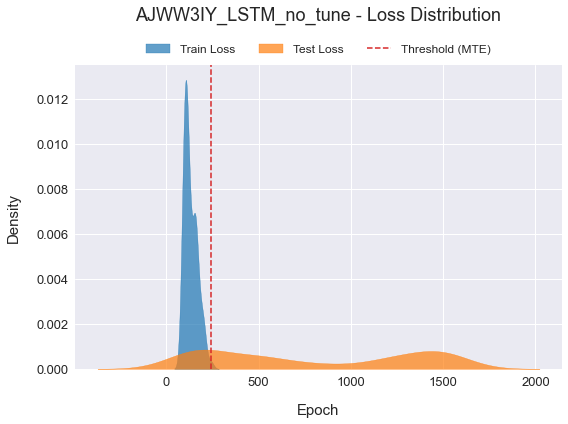


Metrics
{'Threshold': 'MTE', 'Detection': 'Early', 'Total': 187, 'TP': 112, 'FP': 1, 'FN': 0, 'TN': 74, 'Sensitivity': 1.0, 'Specificity': 0.9866666666666667, 'PPV': 0.9911504424778761, 'NPV': 1.0, 'Precision': 0.9911504424778761, 'Recall': 1.0, 'Fbeta': 0.9912372940764108, 'F1': 0.9955555555555555}

RHR Plot


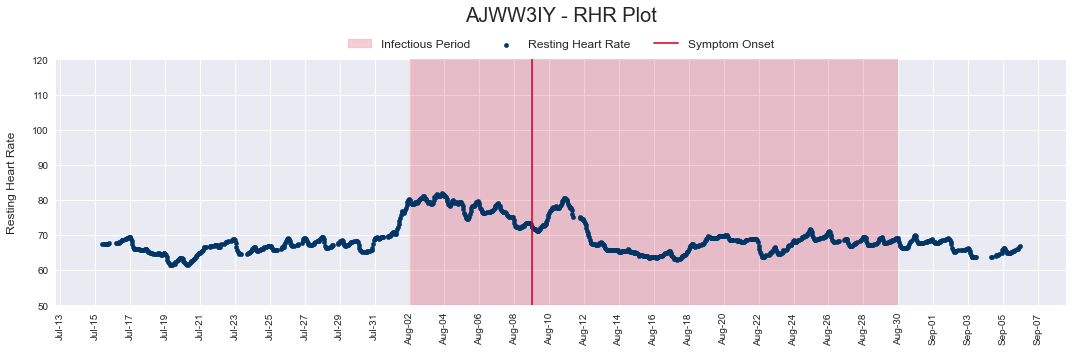


Anomaly Plot


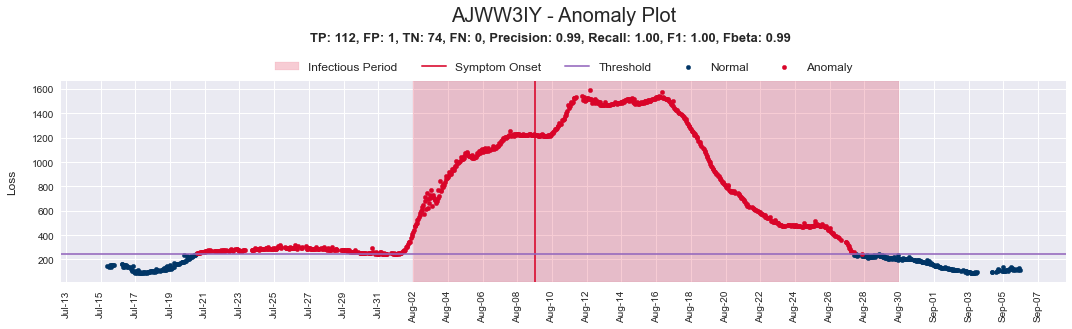

In [14]:
threshold_dict = {
    'MTE': train_loss.max(),
    # 'STE': train_loss.mean() + (3 * train_loss.std())
}

print("\nLoss Distribution Plot")
print("======================", end="\n")
plot.loss_dist(config, train_loss, test_loss, threshold_dict, ref=f"{data.id}_LSTM_no_tune",
               save_plot=True, close_plot=False)

metrics, loss_df_dict = evaluate_model(config, data, train_loss, test_loss,
                                       seq_loss, threshold_dict, ref=f"{data.id}_LSTM_no_tune")
print("\nMetrics")
print("=======", end="\n")
print(metrics)

print("\nRHR Plot")
print("========", end="\n")
# Plot RHR wrt infectious period
plot.rhr_plot(config, loss_df_dict['all'], data.date_dict, title=f"{data.id} - RHR Plot",
              ref=f"{data.id}_LSTM_no_tune", save_plot=True, close_plot=False)

print("\nAnomaly Plot")
print("=============", end="\n")
# Plot anomalies
plot.anomaly_plot(config, loss_df_dict['all'], data.date_dict, threshold_dict['MTE'],
                  metrics, title=f"{data.id} - Anomaly Plot", ref=f"{data.id}_LSTM_no_tune",
                  save_plot=True, close_plot=False)


In [15]:
def anomaly_plot(config, result_df, date_dict, threshold, metrics, title,
                 ref="", save_plot=False, close_plot=False):

    plt.style.use('seaborn')
    plt.rcParams['font.family'] = "Arial"  # "Bahnschrift"
    plt.rcParams['figure.figsize'] = 15, 5

    result_df.index.name = 'datetime'

    fig, ax = plt.subplots()

    ax.axvspan(date_dict['onset'], date_dict['after_14'],
               color='#d90429',
               label='Infectious Period',
               alpha=0.2)

    ax.axvline(date_dict['onset'],
               color='#d90429',
               label='Symptom Onset',
               linestyle='solid',
               lw=2,
               alpha=0.8)

    plt.axhline(y=threshold,
                color='tab:purple',
                linestyle='solid',
                lw=2,
                alpha=0.8,
                label='Threshold')

    # plot anomaly scores
    col_name = f"pred_anomaly"
    normal = result_df.loc[result_df[col_name] == False].reset_index()
    anomaly = result_df.loc[result_df[col_name] == True].reset_index()

    ax.scatter(normal['datetime'], normal['loss'], s=20,
               c='#003566',
               label='Normal')
    ax.scatter(anomaly['datetime'], anomaly['loss'], s=20,
               c='#d90429',
               label='Anomaly')

    # Format x ticks
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('center')

    plt.xticks(rotation=90)

    # Plot info
    plt.title(title, fontsize=20, pad=60)
    # Add subtitle
    subtitle = f'TP: {metrics["TP"]}, FP: {metrics["FP"]}, TN: {metrics["TN"]}, ' + \
               f'FN: {metrics["FN"]}, Precision: {metrics["Precision"]:0.2f}, ' + \
               f'Recall: {metrics["Recall"]:0.2f}, F1: {metrics["F1"]:0.2f}, ' + \
               f'Fbeta: {metrics["Fbeta"]:0.2f}'
    plt.suptitle(subtitle, size=13, x=0.513,
                 y=0.835, fontweight='bold')
    plt.ylabel('Loss', fontsize=12, labelpad=15)
    plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), fontsize=12,
               loc="lower center", borderaxespad=0, ncol=5)

    if save_plot == True:
        plt.tight_layout()
        fig.savefig(f"{config['EXP_DIR']}/{ref}_anomaly_plot.pdf",
                    bbox_inches='tight')

    if close_plot == True:
        plt.close()
    else:
        plt.show()
